# Here is your task
After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data. [dataset](https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1683142174343/Nat_Gas.csv).

Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 📊



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [131]:
df = pd.read_csv('https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1683142174343/Nat_Gas.csv')
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [133]:
df.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [134]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

In [135]:
print(df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())


Dates     0
Prices    0
dtype: int64
Duplicate rows: 0


In [136]:
df = df.sort_values(by='Dates') #sorting according to dates to get the correct order of dates
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df.head()

,Dates,Prices,Year,Month,Day
0,2020-10-31,10.1,2020,10,31
1,2020-11-30,10.3,2020,11,30
2,2020-12-31,11.0,2020,12,31
3,2021-01-31,10.9,2021,1,31
4,2021-02-28,10.9,2021,2,28


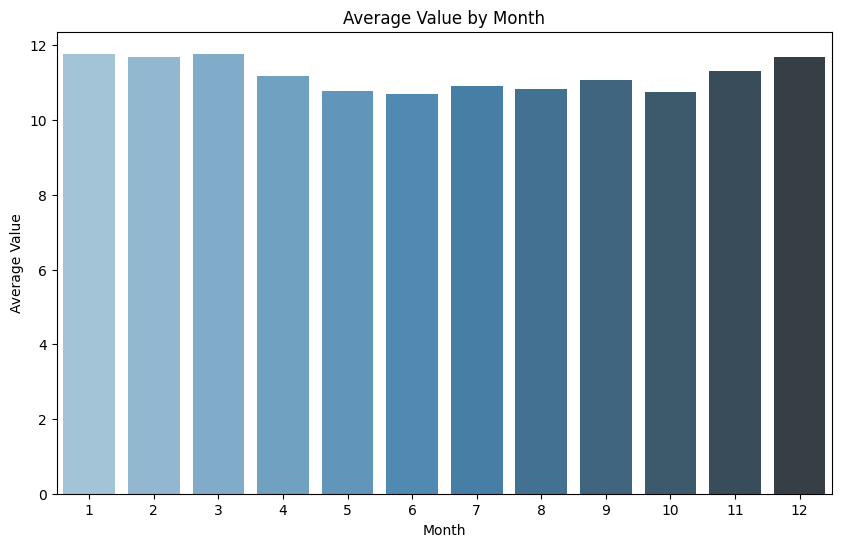

In [137]:
monthly_avg = df.groupby('Month')['Prices'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="Blues_d")
plt.title("Average Value by Month")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.show()

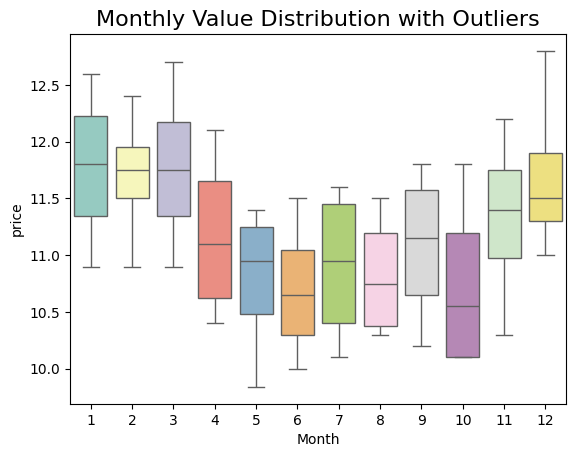

In [138]:
sns.boxplot(x='Month', y='Prices', data=df, palette="Set3")

plt.title("Monthly Value Distribution with Outliers", fontsize=16)
plt.xlabel("Month")
plt.ylabel("price")
plt.show()

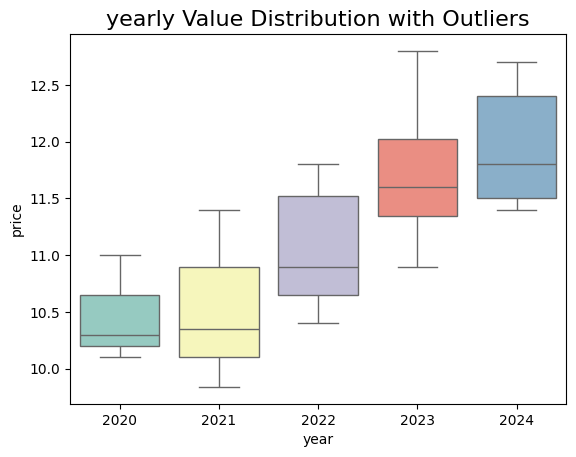

In [139]:
sns.boxplot(x='Year', y='Prices', data=df, palette="Set3")

plt.title("yearly Value Distribution with Outliers", fontsize=16)
plt.xlabel("year")
plt.ylabel("price")
plt.show()

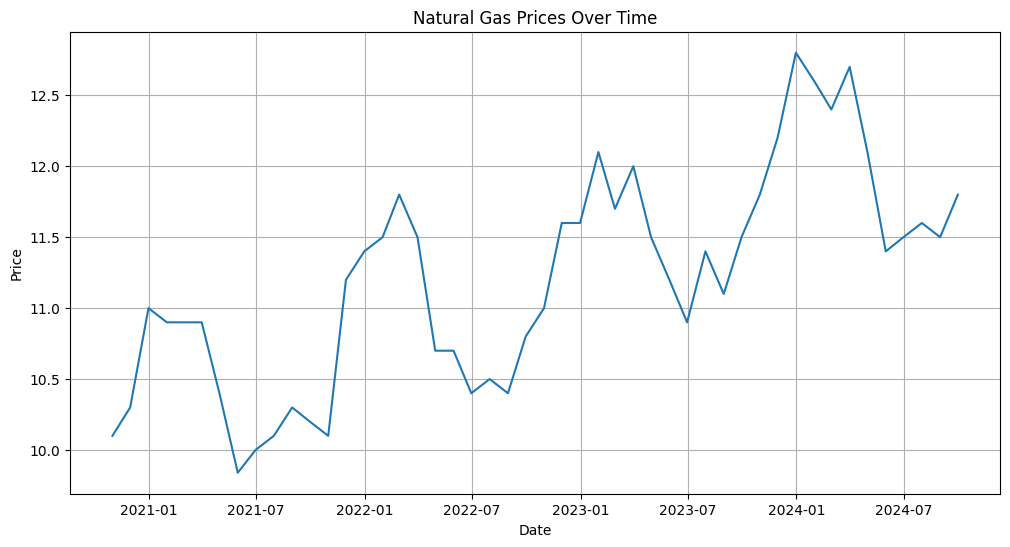

In [140]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Dates', y='Prices', data=df)
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


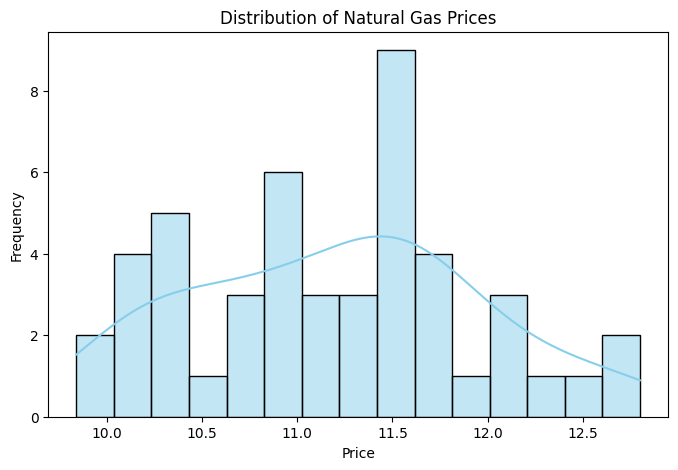

In [141]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Prices'], bins=15, kde=True, color='skyblue')
plt.title('Distribution of Natural Gas Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

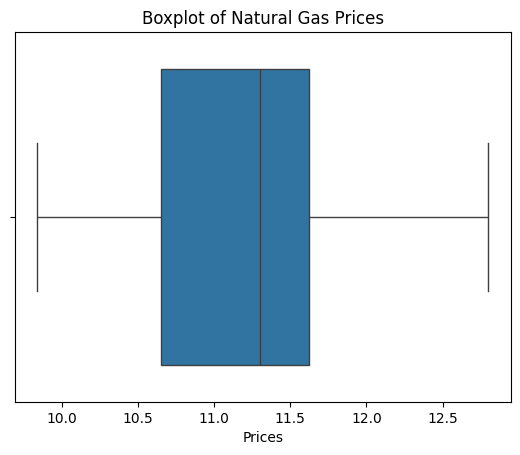

In [142]:
sns.boxplot(x=df['Prices'])
plt.title('Boxplot of Natural Gas Prices')
plt.show()

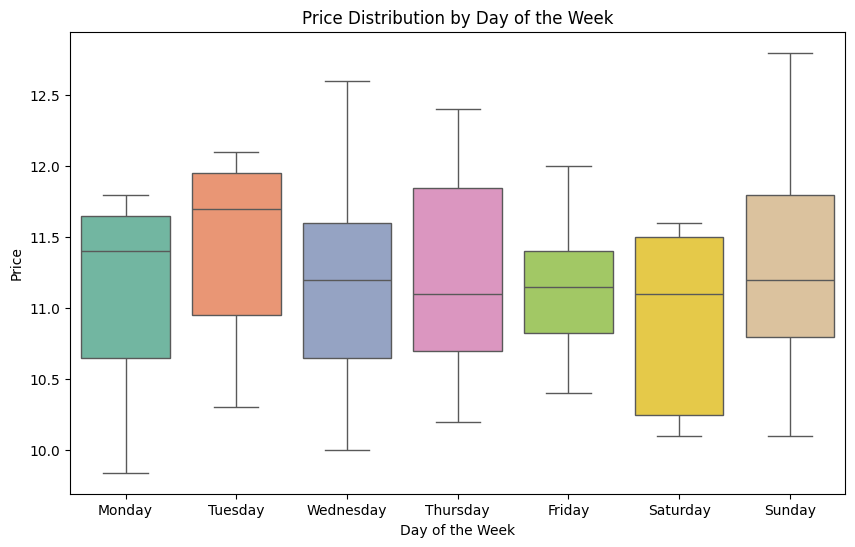

In [143]:
df['DayOfWeek'] = df['Dates'].dt.day_name()

plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Prices', data=df, palette="Set2", order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Price Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()



In [144]:
df.head()

,Dates,Prices,Year,Month,Day,DayOfWeek
0,2020-10-31,10.1,2020,10,31,Saturday
1,2020-11-30,10.3,2020,11,30,Monday
2,2020-12-31,11.0,2020,12,31,Thursday
3,2021-01-31,10.9,2021,1,31,Sunday
4,2021-02-28,10.9,2021,2,28,Sunday


In [145]:
#oneHot-Encoding
day_dummies = pd.get_dummies(df['DayOfWeek'], prefix='DoW').astype(int)
df = pd.concat([df.drop('DayOfWeek', axis=1), day_dummies], axis=1)

In [146]:
scaler=StandardScaler()
df_scaled = df.copy()
df_scaled['Prices_scaled'] = scaler.fit_transform(df[['Prices']])


In [147]:
# Preparing data for regression models
print("Data preparation for regression algorithms:")
print("="*50)

# For regression models, your current scaling approach is optimal:
# 1. Temporal features (Year, Month, Day) should NOT be scaled - they represent meaningful time relationships
# 2. Price scaling is good for target variable normalization
# 3. One-hot encoded features (DoW_*) are already properly scaled (0/1)

# Let's prepare features for regression
feature_columns = ['Year', 'Month', 'Day'] + [col for col in df.columns if col.startswith('DoW_')]
target_column = 'Prices'

print(f"Feature columns: {feature_columns}")
print(f"Target column: {target_column}")
print(f"Total features: {len(feature_columns)}")

# Create feature matrix and target vector
X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Display first few rows
print("\nFirst 5 rows of feature matrix:")
print(X.head())

Data preparation for regression algorithms:
Feature columns: ['Year', 'Month', 'Day', 'DoW_Friday', 'DoW_Monday', 'DoW_Saturday', 'DoW_Sunday', 'DoW_Thursday', 'DoW_Tuesday', 'DoW_Wednesday']
Target column: Prices
Total features: 10

Feature matrix shape: (48, 10)
Target vector shape: (48,)

First 5 rows of feature matrix:
   Year  Month  Day  DoW_Friday  DoW_Monday  DoW_Saturday  DoW_Sunday  \
0  2020     10   31           0           0             1           0   
1  2020     11   30           0           1             0           0   
2  2020     12   31           0           0             0           0   
3  2021      1   31           0           0             0           1   
4  2021      2   28           0           0             0           1   

   DoW_Thursday  DoW_Tuesday  DoW_Wednesday  
0             0            0              0  
1             0            0              0  
2             1            0              0  
3             0            0              0  
4     

In [148]:
# Using train_test_split as requested
# Note: For time series, chronological split is usually better to avoid data leakage
# But using train_test_split for random splitting as requested

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Show date ranges for the random split
train_indices = X_train.index
test_indices = X_test.index

print(f"Training dates range: {df.loc[train_indices, 'Dates'].min()} to {df.loc[train_indices, 'Dates'].max()}")
print(f"Test dates range: {df.loc[test_indices, 'Dates'].min()} to {df.loc[test_indices, 'Dates'].max()}")

Training set: 38 samples
Test set: 10 samples
Training dates range: 2020-10-31 00:00:00 to 2024-09-30 00:00:00
Test dates range: 2021-02-28 00:00:00 to 2024-05-31 00:00:00


In [149]:
# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

print("Model Performance Comparison:")
print("="*60)

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Model': model
    }
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

# Find best model
best_model_name = min(results.keys(), key=lambda x: results[x]['RMSE'])
best_model = results[best_model_name]['Model']

print(f"\n\nBest Model: {best_model_name}")
print(f"Best RMSE: {results[best_model_name]['RMSE']:.4f}")

Model Performance Comparison:

Linear Regression:
  RMSE: 0.6074
  MAE:  0.5592
  R²:   0.2315

Ridge Regression:
  RMSE: 0.5878
  MAE:  0.5420
  R²:   0.2802

Lasso Regression:
  RMSE: 0.5054
  MAE:  0.4681
  R²:   0.4678

Random Forest:
  RMSE: 0.3659
  MAE:  0.3060
  R²:   0.7210

Gradient Boosting:
  RMSE: 0.2825
  MAE:  0.2288
  R²:   0.8337


Best Model: Gradient Boosting
Best RMSE: 0.2825


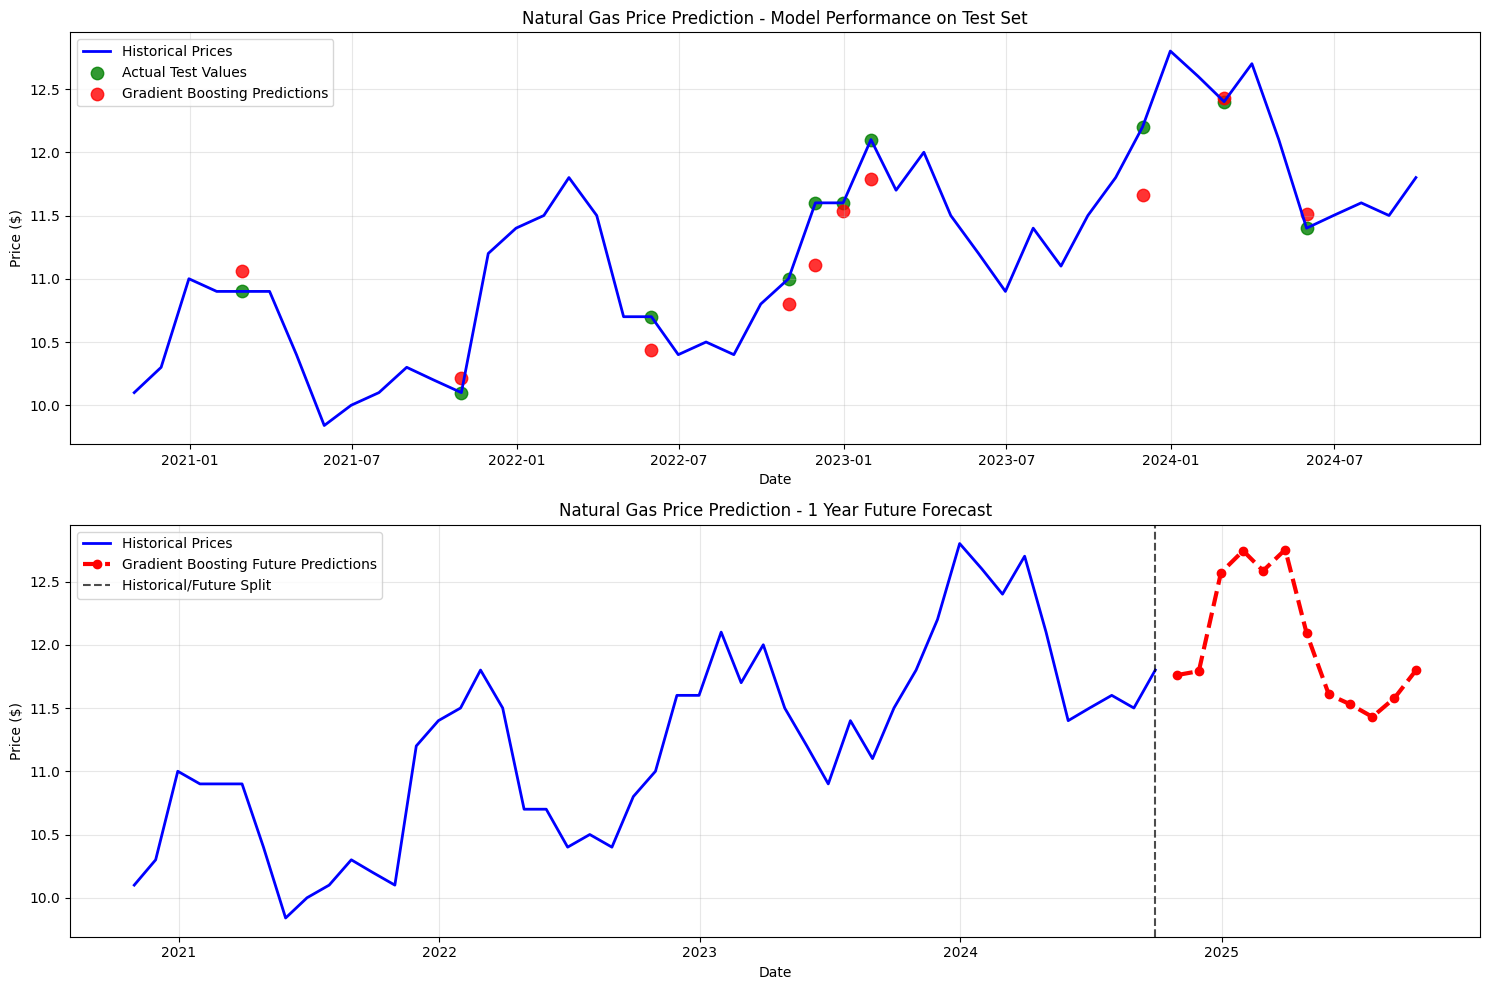


Future Price Predictions (Next 12 Months) using Gradient Boosting:
2024-10-31: $11.76
2024-11-30: $11.79
2024-12-31: $12.57
2025-01-31: $12.74
2025-02-28: $12.58
2025-03-31: $12.75
2025-04-30: $12.09
2025-05-31: $11.61
2025-06-30: $11.53
2025-07-31: $11.43
2025-08-31: $11.58
2025-09-30: $11.80

Summary:
Historical price range: $9.84 - $12.80
Future predicted range: $11.43 - $12.75
Average future price: $12.02
Model R² Score: 0.8337


In [150]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 10))

# Plot 1: Model predictions vs actual
plt.subplot(2, 1, 1)
plt.plot(df['Dates'], df['Prices'], 'b-', label='Historical Prices', linewidth=2)

# Plot test predictions
test_dates = df.loc[test_indices, 'Dates'].sort_values()
y_test_sorted = df.loc[test_dates.index, 'Prices']
y_pred_sorted = best_model.predict(X.loc[test_dates.index])

plt.scatter(test_dates, y_test_sorted, color='green', s=80, label='Actual Test Values', alpha=0.8)
plt.scatter(test_dates, y_pred_sorted, color='red', s=80, label=f'{best_model_name} Predictions', alpha=0.8)

plt.title('Natural Gas Price Prediction - Model Performance on Test Set')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Future predictions
plt.subplot(2, 1, 2)

# Generate future dates (12 months)
last_date = df['Dates'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Create future feature matrix
future_features = []
for date in future_dates:
    # Get day of week for the last day of each month
    day_of_week = date.day_name()
    
    # Create feature row
    row = {
        'Year': date.year,
        'Month': date.month,
        'Day': date.day,
        'DoW_Friday': 1 if day_of_week == 'Friday' else 0,
        'DoW_Monday': 1 if day_of_week == 'Monday' else 0,
        'DoW_Saturday': 1 if day_of_week == 'Saturday' else 0,
        'DoW_Sunday': 1 if day_of_week == 'Sunday' else 0,
        'DoW_Thursday': 1 if day_of_week == 'Thursday' else 0,
        'DoW_Tuesday': 1 if day_of_week == 'Tuesday' else 0,
        'DoW_Wednesday': 1 if day_of_week == 'Wednesday' else 0
    }
    future_features.append(row)

X_future = pd.DataFrame(future_features)
y_future_pred = best_model.predict(X_future)

# Plot extended predictions
plt.plot(df['Dates'], df['Prices'], 'b-', label='Historical Prices', linewidth=2)
plt.plot(future_dates, y_future_pred, 'r--', label=f'{best_model_name} Future Predictions', linewidth=3, marker='o', markersize=6)

plt.axvline(x=last_date, color='black', linestyle='--', alpha=0.7, label='Historical/Future Split')
plt.title('Natural Gas Price Prediction - 1 Year Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFuture Price Predictions (Next 12 Months) using {best_model_name}:")
print("="*60)
for date, price in zip(future_dates, y_future_pred):
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")
    
print(f"\nSummary:")
print(f"Historical price range: ${df['Prices'].min():.2f} - ${df['Prices'].max():.2f}")
print(f"Future predicted range: ${y_future_pred.min():.2f} - ${y_future_pred.max():.2f}")
print(f"Average future price: ${y_future_pred.mean():.2f}")
print(f"Model R² Score: {results[best_model_name]['R²']:.4f}")

In [ ]:
def predict_price_for_date(date_input, model=best_model):
    """
    Predict natural gas price for any given date.
    
    Parameters:
    date_input: str or datetime - Date in format 'YYYY-MM-DD' or datetime object
    model: trained model (default: best_model from our comparison)
    
    Returns:
    float: predicted price for the given date
    """
    # Convert string to datetime if needed
    if isinstance(date_input, str):
        date_obj = pd.to_datetime(date_input)
    else:
        date_obj = date_input
    
    # Extract features from the date
    year = date_obj.year
    month = date_obj.month
    day = date_obj.day
    day_of_week = date_obj.day_name()
    
    # Create feature vector
    features = {
        'Year': year,
        'Month': month,
        'Day': day,
        'DoW_Friday': 1 if day_of_week == 'Friday' else 0,
        'DoW_Monday': 1 if day_of_week == 'Monday' else 0,
        'DoW_Saturday': 1 if day_of_week == 'Saturday' else 0,
        'DoW_Sunday': 1 if day_of_week == 'Sunday' else 0,
        'DoW_Thursday': 1 if day_of_week == 'Thursday' else 0,
        'DoW_Tuesday': 1 if day_of_week == 'Tuesday' else 0,
        'DoW_Wednesday': 1 if day_of_week == 'Wednesday' else 0
    }
    
    # Convert to DataFrame with same column order as training data
    feature_df = pd.DataFrame([features])[feature_columns]
    
    # Make prediction
    predicted_price = model.predict(feature_df)[0]
    
    return predicted_price






Natural Gas Price Prediction Function


In [50]:
print("Natural Gas Price Prediction Function")
print("="*50)
# Use the actual test_dates from the test set (from df['Dates'] using test_indices)
test_dates = df.loc[test_indices, 'Dates']
for date_str in test_dates:
    predicted_price = predict_price_for_date(date_str)
    date_obj = pd.to_datetime(date_str)
    print(f"{date_str} ({date_obj.strftime('%A')}): ${predicted_price:.2f}")

print(f"\nUsing model: {best_model_name}")
print(f"Model accuracy (R²): {results[best_model_name]['R²']:.4f}")

Natural Gas Price Prediction Function
2023-01-31 00:00:00 (Tuesday): $11.79
2024-02-29 00:00:00 (Thursday): $12.43
2022-12-31 00:00:00 (Saturday): $11.54
2024-05-31 00:00:00 (Friday): $11.51
2022-10-31 00:00:00 (Monday): $10.80
2023-11-30 00:00:00 (Thursday): $11.66
2021-10-31 00:00:00 (Sunday): $10.21
2022-05-31 00:00:00 (Tuesday): $10.44
2021-02-28 00:00:00 (Sunday): $11.06
2022-11-30 00:00:00 (Wednesday): $11.11

Using model: Gradient Boosting
Model accuracy (R²): 0.8337


In [ ]:
joblib.dump(best_model, '../models/gradient_boost.pkl')

['../models/gradient_boost.pkl']